<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# Greenhouse Environment

In this notebook we are going to take the simulation model developed in the previous notebook and use Reinforcement Learning to train an agent for controling the greenhouse decision variables. We are going to use OpenAI Gym interface, since it allows for an easy reuse of the agents across different environments and domains.

## Interface
In order to comply with Gym interface we would need our class to have two attributes:
- ```env.observation_space``` - observation space of the environment
- ```env.action_space``` - action space of the environment
`env.observation_space` will define the **Observation Space**, the space of all possible observations that an agent can receive. At the same time `env.action_space` determines the **Action Space**, space of all possible actions. When constructing an agent we will use this information to define the size of a table or a neural network.

Communication between the environment and the agent will be done through the following methods:
- ```env.reset()``` - resets the state of the environment and returns an initial observation.
- ```env.step(action)``` - run one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling ```reset()``` to reset this environment's state.

When calling the `env.reset()` we need to return an initial *observation*.

```python
obs = env.reset()
```

When `env.step()` is called we need to return a tuple with 4 values:
1. Next observation
2. Reward for the previous action
3. A boolean flag whether an episode is done or not
4. Dictionary with some other information

```python
next_obs, reward, done, info = env.reset()
```


```python
class GreenhouseEnv(gym.Env):
    def __init__(self, config=None):
        super(GreenhouseEnv, self).__init__()
        self.config = config or dict()
        self.max_episode_time = self.config.get('max_episode_time', 7 * 24 * 60)

        greenhouse_config = self.config.get('greenhouse_config', dict())
        self.greenhouse_model = Greenhouse(weather_model=Weather(), **greenhouse_config)

        sample_obs = self.greenhouse_model.reset()
        high = np.array([np.inf] * sample_obs.size())
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        # Define the range of values available for actions
        ranges = [
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
        ]
        # Create a cartesian product of all of the actions
        possible_actions = list(product(*ranges))
        # Create a mapping from a number to a vector representation of an action and back
        self.action_vec_to_num = {}
        self.action_num_to_vec = {}
        for i, action in enumerate(possible_actions):
            self.action_vec_to_num[action] = i
            self.action_num_to_vec[i] = action

        self.action_space = spaces.Discrete(len(self.action_vec_to_num))
```
First of all we would like to have a nice way of configuring our environment. For this we are going to pass a configuration dictionary to the `GreenhouseEnv` that contains all of the parameters needed to configure the environment and the simulation.

Next we define `reset()` and `step()` methods. Since we have prepared almost everything in the `Greenhouse` simulation class we only need to pass on the calls to the simulation object and return the observations as a numpy object.
        
```python
class Greenhouse(gym.Env):
    def reset(self):
        obs_np = self.greenhouse_model.reset().to_numpy()
        return obs_np

    def step(self, action):
        # if action is an integer covert it into a vector form
        if isinstance(action, int):
            action = self.action_num_to_vec[action]
        
        # create a greenhouse action
        greenhouse_action = GreenhouseAction(
            heater=action[0],
            window=action[1],
            vapor_supply=action[2],
            CO2_supply=action[3],
            light=action[4],
        )
        
        # perform a step in a simulation
        greenhouse_state, reward, reward_dict = self.greenhouse_model.step(greenhouse_action)

        done = self.greenhouse_model.time >= self.max_episode_time
        info = {**reward_dict}

        return greenhouse_state.to_numpy(), reward, done, info
```

# State modeling

When taking into the account the state of the environment it is important to check what kind of values can you expect. For now, we just took the numbers provided by a simulation model. Run the environment couple of times, collect the data and check the statistics of our data. 

In [1]:
%load_ext autoreload
%autoreload 2

from greenhouse.environment import GreenhouseEnv
import numpy as np

env = GreenhouseEnv()

def sample_random_trajectories(env, num_episodes=100):
    obs = env.reset()
    done = False
    observed_values = []
    from collections import defaultdict
    step_info = defaultdict(list)
    for i in range(num_episodes):
        while not done:
            action = env.action_space.sample()
            next_obs, reward, done, info = env.step(action)
            observed_values.append(obs)
            obs = next_obs
    observed_values = np.asarray(observed_values)
    return observed_values
random_trajectories = sample_random_trajectories(env)

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
import pandas as pd
state = env.greenhouse_model.reset()
pd.DataFrame(random_trajectories, columns=state.labels()).describe()

,Time [min],GH Temperature [C],GH Rel. Humidity [%],GH CO2 [ppm],Weather | Temperature [C],Weather | Rel. Humidity [%],Weather | Solar power [W/m2],Weather | CO2 [ppm],Plant | CO2 absorption rate [g/m2/h],Plant | CO2 total [gram]
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.0,2016.000000,2016.000000
mean,5037.500000,26.451725,63.212536,1427.912634,18.788442,76.506448,150.229167,350.0,-0.000149,45.268282
std,2910.566955,6.095527,14.188214,513.564580,1.640002,10.506837,209.185639,0.0,0.000140,26.681075
min,0.000000,17.956776,23.818641,333.333333,15.000000,43.000000,0.000000,350.0,-0.000389,-0.508333
25%,2518.750000,21.889447,52.779633,999.297326,17.700000,69.900000,0.000000,350.0,-0.000280,23.946592
50%,5037.500000,24.306251,67.297092,1356.184532,18.800000,78.200000,55.000001,350.0,-0.000164,46.004649
75%,7556.250000,29.851989,74.732891,1834.754221,19.900000,84.000000,227.000000,350.0,0.000028,66.951752
max,10075.000000,45.264955,88.001894,2791.019022,23.000000,94.400000,879.999999,350.0,0.000028,90.486062


C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Text(0, 0.5, 'time [minutes]')

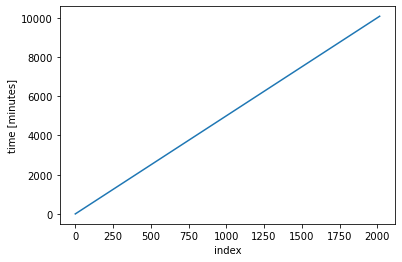

In [3]:
env = GreenhouseEnv()

random_traj = sample_random_trajectories(env, num_episodes=1)

import matplotlib.pyplot as plt

plt.plot(random_traj[:, 0])
plt.xlabel('index')
plt.ylabel('time [minutes]')

We know that time is going to get incremented by 5 every timestep. We could transform this feature with some cyclic function, so that our agent can get the notion of day and night. We are going to add two features for time.

$$
    x_0 = \operatorname{sin} \left( \frac{t * 2 \pi}{24 * 60} \right)
$$


$$
    x_1 = \operatorname{cos} \left( \frac{t * 2 \pi}{24 * 60} \right)
$$

For all the other features we are going to normalize them between -1 and 1 using **min-max** normalization. The minumum and maximum of the real values we are going to estimate from a number of random trajectories.

In [4]:
def min_max_normalize(v, low_v, high_v, low_target, high_target):
    """
    Rescale the value one range [low_v, high_v] to another [low_target, high_target]
    Formula taken from here: https://en.wikipedia.org/wiki/Feature_scaling
    :param v: value to rescale
    :param low_v: min(v) lowest value for v
    :param high_v: max(v) highest value for v
    :param low_target: a lower after rescale
    :param high_target: b higher after rescale
    :return: v_rescaled
    """
    if high_v - low_v == 0:
        v_rescaled = 0
    else:
        v_rescaled = low_target + (v - low_v) * (high_target - low_target) / (
            high_v - low_v
        )
    return v_rescaled


# Record min and max for all features
scaling_values = {}
for i in range(random_trajectories.shape[1]):
    min_, max_ = random_trajectories[:, i].min(), random_trajectories[:, i].max()
    scaling_values[i] = (min_, max_)

In [5]:
import gym
import numpy as np

class TransformObservation(gym.ObservationWrapper):
    def __init__(self, config):
        super().__init__(config)
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, shape=(self.observation_space.shape[0] + 1, ))
    
    
    def normalize_features(self, obs):
        new_obs = np.zeros(obs.shape[0] + 1, dtype=np.float32)
        new_obs[0] = np.sin(obs[0] * 2 * np.pi / (24 * 60))
        new_obs[1] = np.cos(obs[0] * 2 * np.pi / (24 * 60))

        for i in range(2, len(obs)):
            low_v, high_v = scaling_values[i - 1]
            new_obs[i] = min_max_normalize(obs[i - 1], low_v, high_v, -1, 1)

        return new_obs
    
    def observation(self, obs):
        return self.normalize_features(obs)

env = TransformObservation(GreenhouseEnv())

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
random_trajectory_normalized = sample_random_trajectories(env, 1)
pd.DataFrame(random_trajectory_normalized).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,2.016000e+03,2.016000e+03,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.0,2016.000000,2016.0
mean,0.000000e+00,0.000000e+00,-0.398834,0.235252,-0.139421,-0.052889,0.303753,-0.658570,0.0,0.148480,0.0
std,7.072822e-01,7.072822e-01,0.439880,0.439458,0.406864,0.410000,0.408826,0.475422,0.0,0.677089,0.0
min,-1.000000e+00,-1.000000e+00,-0.989353,-0.869842,-1.034704,-1.000000,-1.000000,-1.000000,0.0,-0.938815,0.0
25%,-7.071068e-01,-7.071068e-01,-0.726439,-0.068388,-0.468406,-0.325000,0.046693,-1.000000,0.0,-0.476583,0.0
50%,-3.673941e-16,1.836970e-16,-0.547815,0.344528,-0.196477,-0.050000,0.369650,-0.875000,0.0,0.045734,0.0
75%,7.071068e-01,7.071068e-01,-0.168169,0.572788,0.174498,0.225000,0.595331,-0.484091,0.0,1.000000,0.0
max,1.000000e+00,1.000000e+00,1.038448,1.022201,0.977476,1.000000,1.000000,1.000000,0.0,1.000000,0.0


Text(0, 0.5, 'time feature')

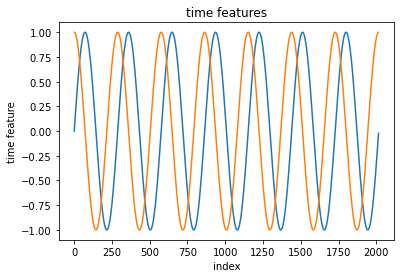

In [7]:
plt.title('time features')

plt.plot(random_trajectory_normalized[:, 0])
plt.plot(random_trajectory_normalized[:, 1])
plt.xlabel('index')
plt.ylabel('time feature')

In [11]:
def visualize_episode(env, agent):
    from collections import defaultdict
    import matplotlib.pyplot as plt
    from greenhouse.simulation import plot_history
    
    history = []
    step_info = defaultdict(list)
    summary = {}
    
    # reset an environment and get first observation
    obs = env.reset()
    done = False
    while not done:
        # get an action from the agent
        action = agent.compute_action(obs)
        # perform an environment step
        next_obs, reward, done, info = env.step(action)
        # get non normalized observation
        non_norm_next_obs = env.greenhouse_model.get_obs().to_numpy()
        # in case the agent's action is an integer convert it to the vector form to save it in a history
        if isinstance(action, int):
            action = env.action_num_to_vec[action]
        history.append(np.concatenate([non_norm_next_obs, action]))
        # prepeare the next observation for the next step
        obs = next_obs
        # save all of the extra variables provided by info
        for k, v in info.items():
            step_info[k].append(v)
            
    plot_history(np.asarray(history))
    plt.show()
    
    history = np.asarray(history)
    day_mask = ((history[:, 0] / 60) % 24 > 5.0) * ((history[:, 0] / 60) % 24 < 23.0)
    summary['mean_day_temp'] = history[:, 1][day_mask].mean()
    summary['mean_night_temp'] = history[:, 1][~day_mask].mean()
    
    # compute cumulative individual rewards
    cumulative_rewards = {}
    for k, v in step_info.items():
        sum_rewards = sum(step_info[k])
        cumulative_rewards[k] = sum_rewards
        summary[k] = sum_rewards
        
    summary['total_cost'] = sum([v for k, v in cumulative_rewards.items() if 'cost' in k])
    summary['total_co2_absorbtion'] = sum([v for k, v in cumulative_rewards.items() if 'cost' not in k])
    summary['total_reward'] = summary['total_cost'] + summary['total_co2_absorbtion']
    
    return history, summary

# Scenario 1: No costs
For the heuristics with no cost it make sense to use as much resourses as possible. In this case we can define a `NoCostHeuristicAgent` will only be tasked to control the temperature in the greenhouse. The CO2 supply and lights will be constantly turned on, because there is no penalty for using them.


In [27]:
class NoCostHeuristicAgent():
    def compute_action(self, state):
        temp = state[1]
        # print(temp)
        if temp > 28.0:
            window = 1
        else:
            window = 0

        if temp < 25.0:
            heater = 1
        else:
            heater = 0
        humidity = state[2]
        if humidity < 80:
            vapor_supply = 1
        else:
            vapor_supply = 0

        # scatterplot: daylight horizontaly and sun intensity
        # find the correlation between the

        action = GreenhouseAction(
            heater=heater,
            window=window,
            vapor_supply=vapor_supply,
            CO2_supply=1,
            light=1
        )
        action = action.to_numpy()
        return action

In [8]:
env_config = {
    'greenhouse_config': {
        'cost_heat': 0,
        'cost_CO2': 0,
        'cost_vapor': 0,
        'cost_light': 0
    }
}

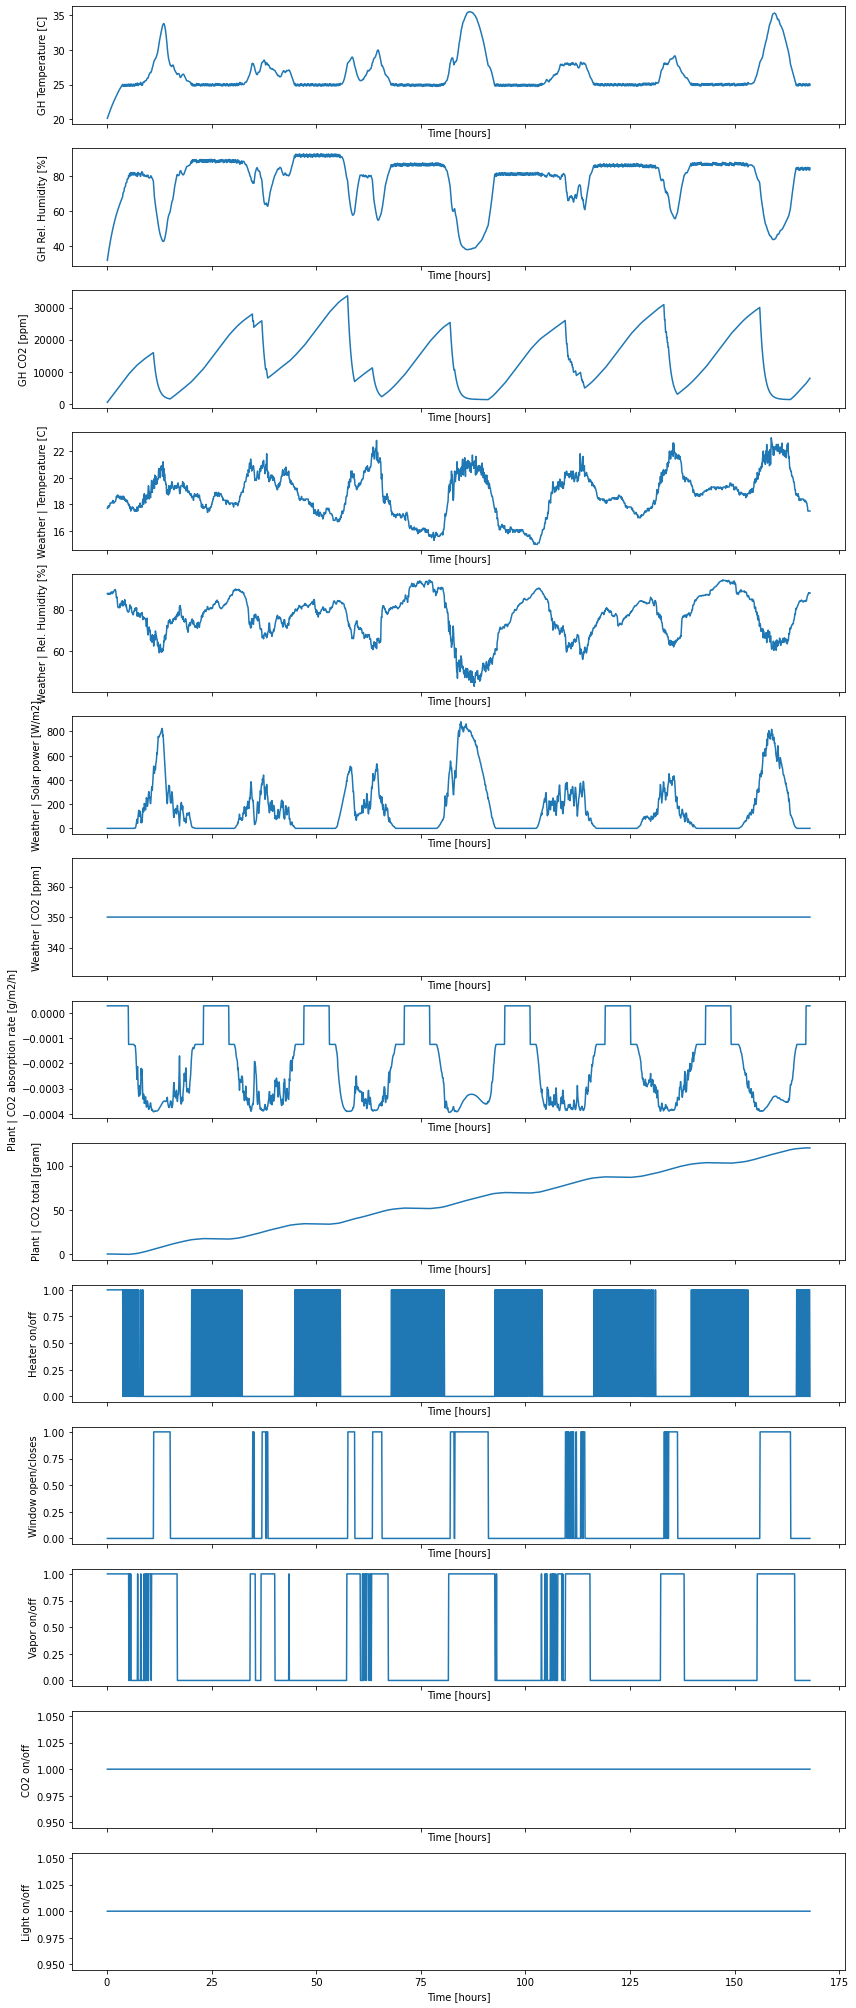

In [28]:
from greenhouse.heuristic_agents import NoCostHeuristicAgent 
from greenhouse.simulation import plot_history
env = GreenhouseEnv(env_config)
heuristic_agent = NoCostHeuristicAgent()

history_heuristic, summary_heuristic = visualize_episode(env, heuristic_agent)

In [39]:
pd.DataFrame(summary_heuristic, index=['heuristic'])

,mean_day_temp,mean_night_temp,cost_vapor,cost_heat,cost_CO2,cost_light,CO2_absorbed,total_cost,total_co2_absorbtion,total_reward
heuristic,27.014404,24.775748,0.0,0.0,0.0,0,800.511931,0.0,800.511931,800.511931


## Controling a Greenhouse with DQN

In [32]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_1')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config))
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.9,
    use_cnn=False,
    mlp_n_hidden=(32, 32, 64),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(128, ),
    mlp_value_act_f="tanh")
# q_network.load(filepath='Experiments/greenhouse_dqn_1/last')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=50000,
    gamma=0.9,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=3,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-5,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# agent.epsilon = 0.02

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (11,), float32)
Action space: Discrete(8)


C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


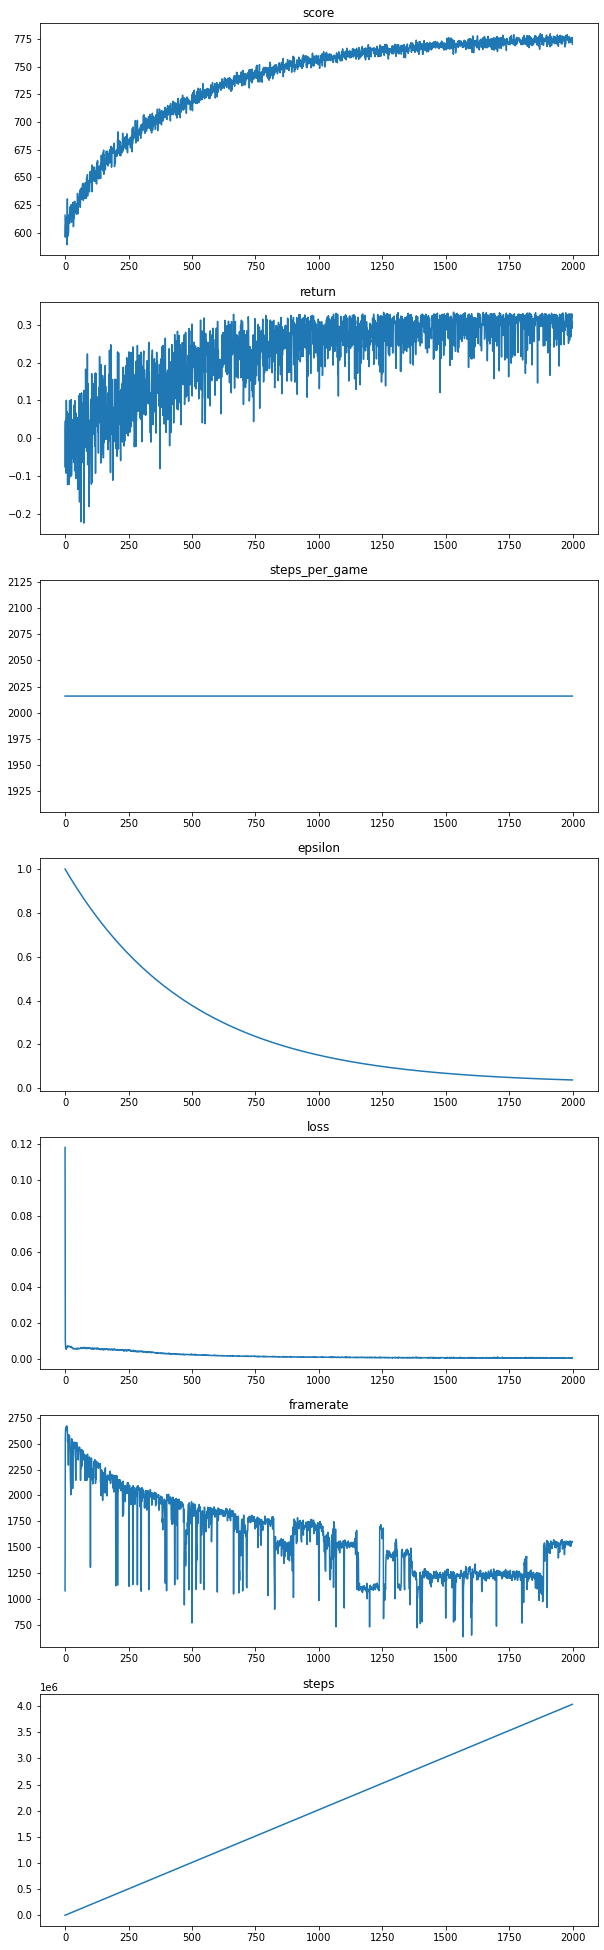

In [21]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=1000, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

Let us compare the performance of the our DQN Agent against the heuristic.

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


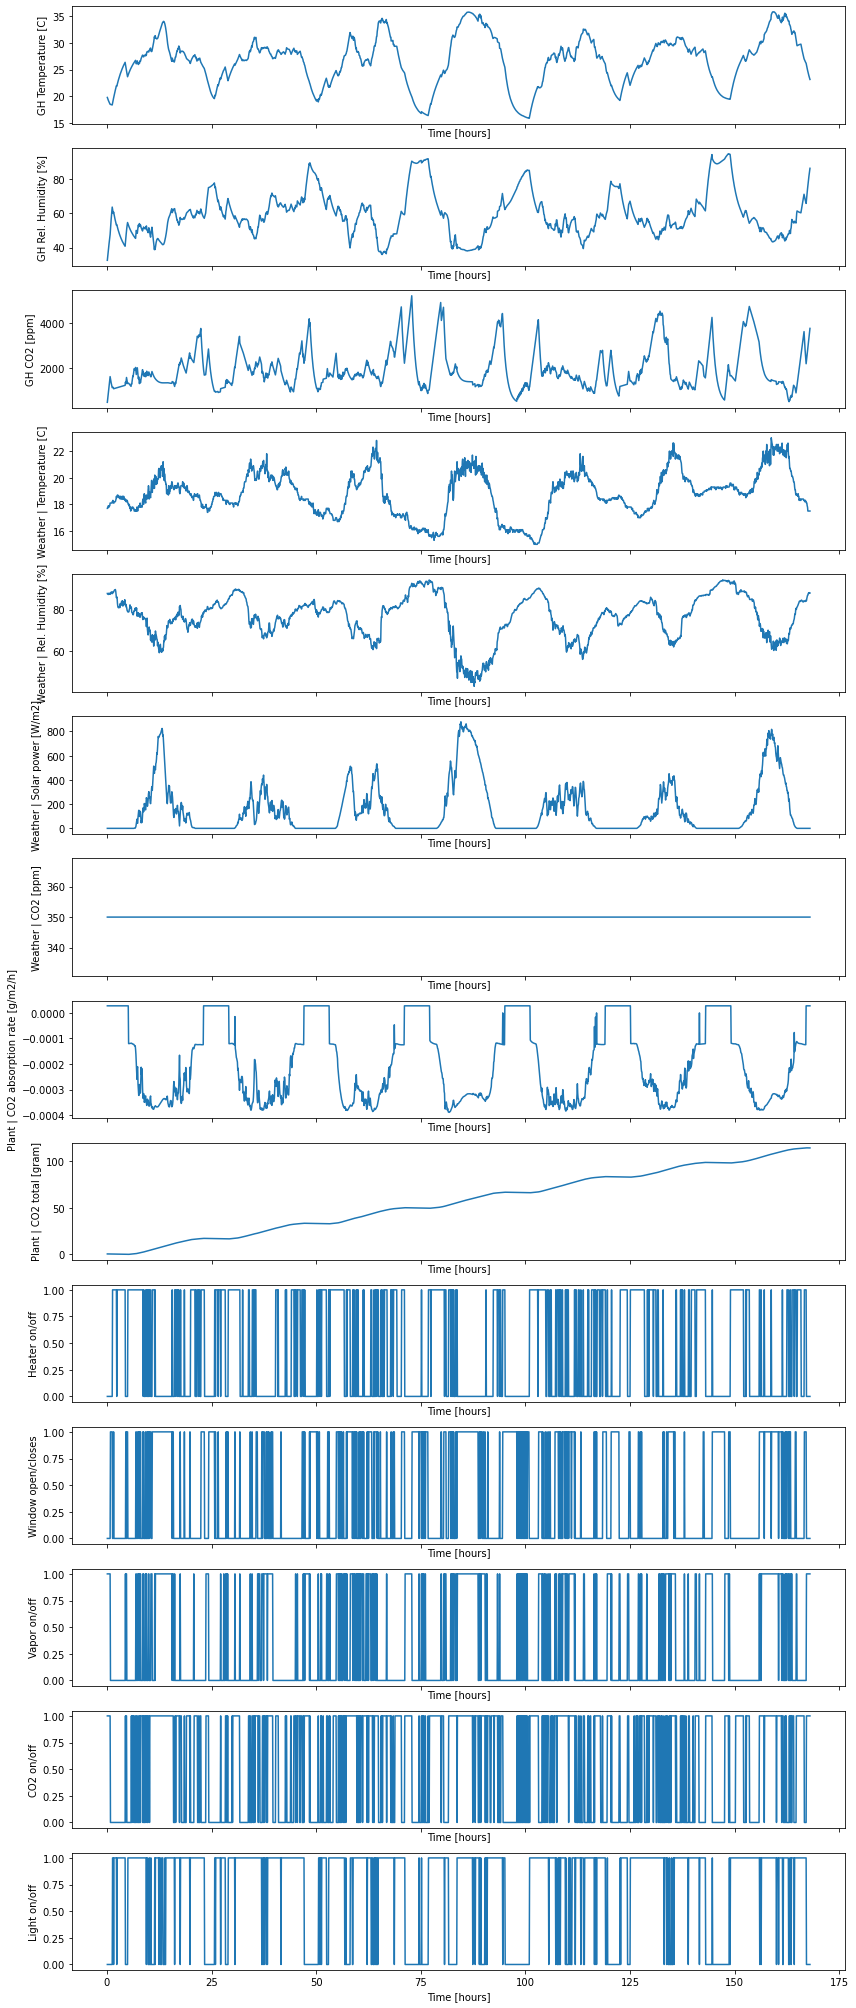

In [22]:
env = TransformObservation(GreenhouseEnv(env_config))
history_rl, summary_rl = visualize_episode(env, agent)

In [29]:
pd.DataFrame([summary_rl, summary_heuristic], index=['rl', 'heuristic'])

,mean_day_temp,mean_night_temp,cost_vapor,cost_heat,cost_CO2,cost_light,CO2_absorbed,total_cost,total_co2_absorbtion,total_reward
rl,28.561374,21.197776,0.0,0.0,0.0,0,764.505760,0.0,764.505760,764.505760
heuristic,27.014404,24.775748,0.0,0.0,0.0,0,800.511931,0.0,800.511931,800.511931


# Scenario 2: Non zero costs
For this purposes we will ajust the heuristic agent, so that it makes use of CO2 and light controles as well.

```python
class HeuristicAgent():
    def compute_action(self, state):

        time = state[0]
        hour = (time % (24 * 12)) / 12

        CO2 = state[3]
        if (hour > 8) & (hour < 20) & (CO2 < 800):
            CO2_supply = 1
        else:
            CO2_supply = 0
        temp = state[1]
        # print(temp)
        if temp > 28.0:
            window = 1
        else:
            window = 0

        if temp < 22.0:
            heater = 1
        else:
            heater = 0
        humidity = state[2]
        if humidity < 80:
            vapor_supply = 1
        else:
            vapor_supply = 0

        if 5 < hour < 23:
            light_supply = 1
        else:
            light_supply = 0

        action = GreenhouseAction(
            heater=heater,
            window=window,
            vapor_supply=vapor_supply,
            CO2_supply=CO2_supply,
            light=light_supply
        )
        action = action.to_numpy()
        return action
```

In [40]:
env_config = {
    'greenhouse_config': {
        'cost_heat': -0.005,  # €/kW/m2
        'cost_CO2': -1000.0,  # €/kg/m2
        'cost_vapor': 0,  # €/kg/m2
        'cost_light': -1 / 7.2e5, # €/umol/m2
    }
}

## Heuristic

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


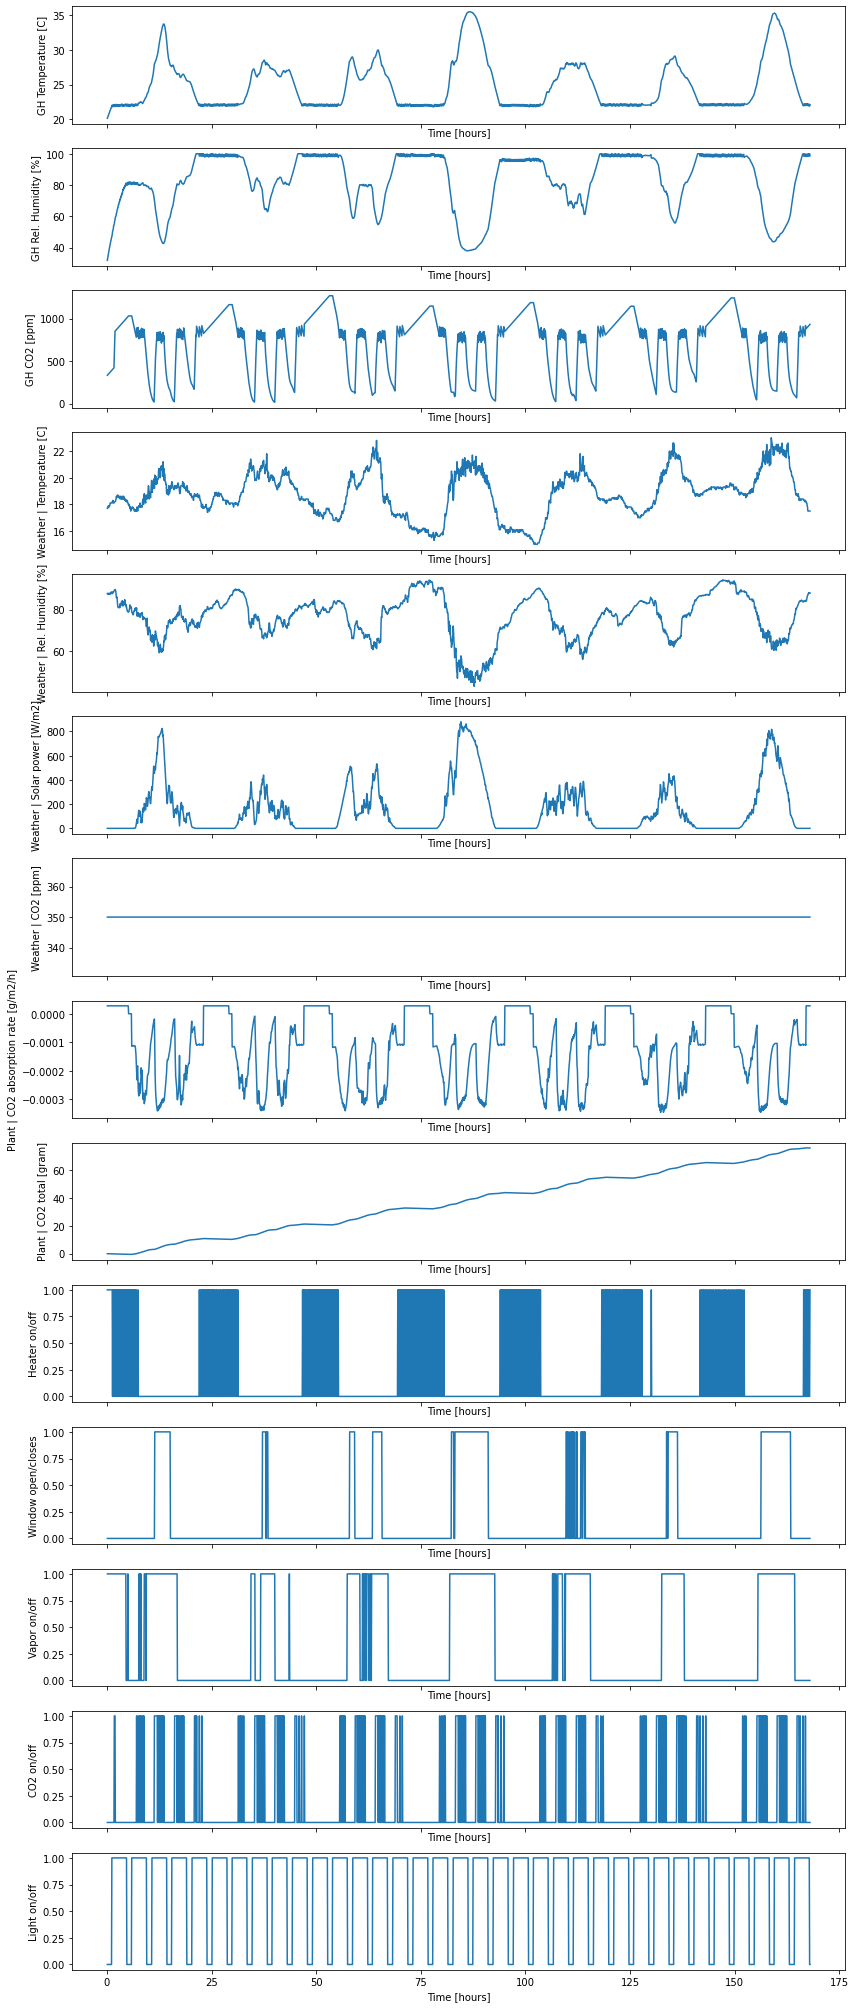

,mean_day_temp,mean_night_temp,cost_vapor,cost_heat,cost_CO2,cost_light,CO2_absorbed,total_cost,total_co2_absorbtion,total_reward
heuristic,25.818741,22.025044,0.0,-57.78,-84.5,-117.264583,505.193589,-259.544583,505.193589,245.649006


In [43]:
from greenhouse.heuristic_agents import HeuristicAgent 
from greenhouse.simulation import plot_history
env = GreenhouseEnv(env_config)
heuristic_agent = HeuristicAgent()

history_heuristic, summary_heuristic = visualize_episode(env, heuristic_agent)
pd.DataFrame(summary_heuristic, index=['heuristic'])

## DQN

In [45]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_2')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config))
    

print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.9,
    use_cnn=False,
    mlp_n_hidden=(32, 32, 64),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(128, ),
    mlp_value_act_f="tanh")
# q_network.load(filepath='Experiments/greenhouse_dqn_2/run100')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.9,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-6,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (11,), float32)
Action space: Discrete(32)


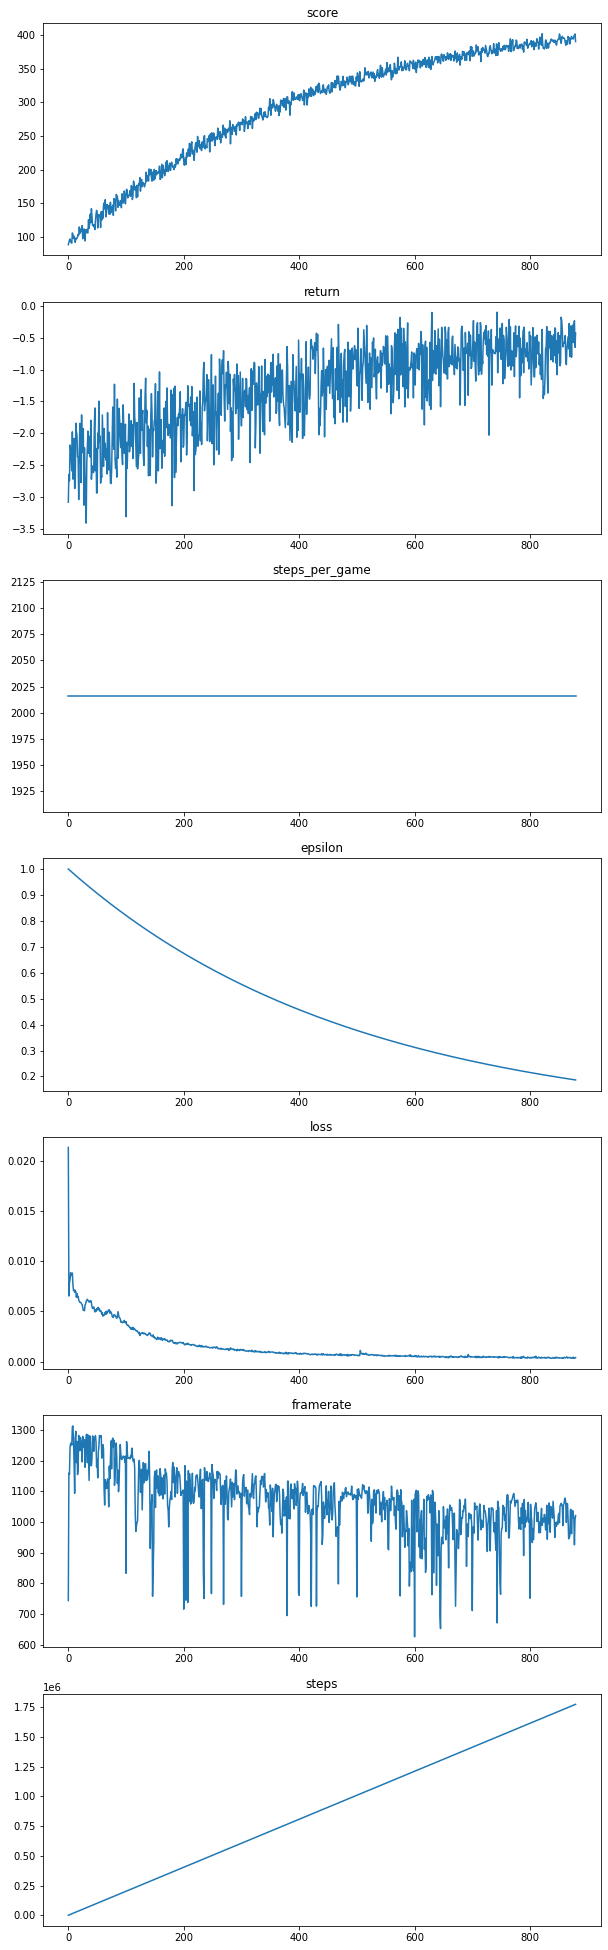

In [ ]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=2000, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

In [ ]:
env = TransformObservation(GreenhouseEnv(env_config))
history_rl, summary_rl = visualize_episode(env, agent)

In [ ]:
pd.DataFrame([summary_rl, summary_heuristic], index=['rl', 'heuristic'])

# Scenario 3: Increased C02 cost

In [20]:
env_config = {
    'greenhouse_config': {
        'cost_heat': -0.005,  # €/kW/m2
        'cost_CO2': -3000.0,  # €/kg/m2
        'cost_vapor': 0,  # €/kg/m2
        'cost_light': -1 / 7.2e5, # €/umol/m2
    }
}

## Heuristic

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


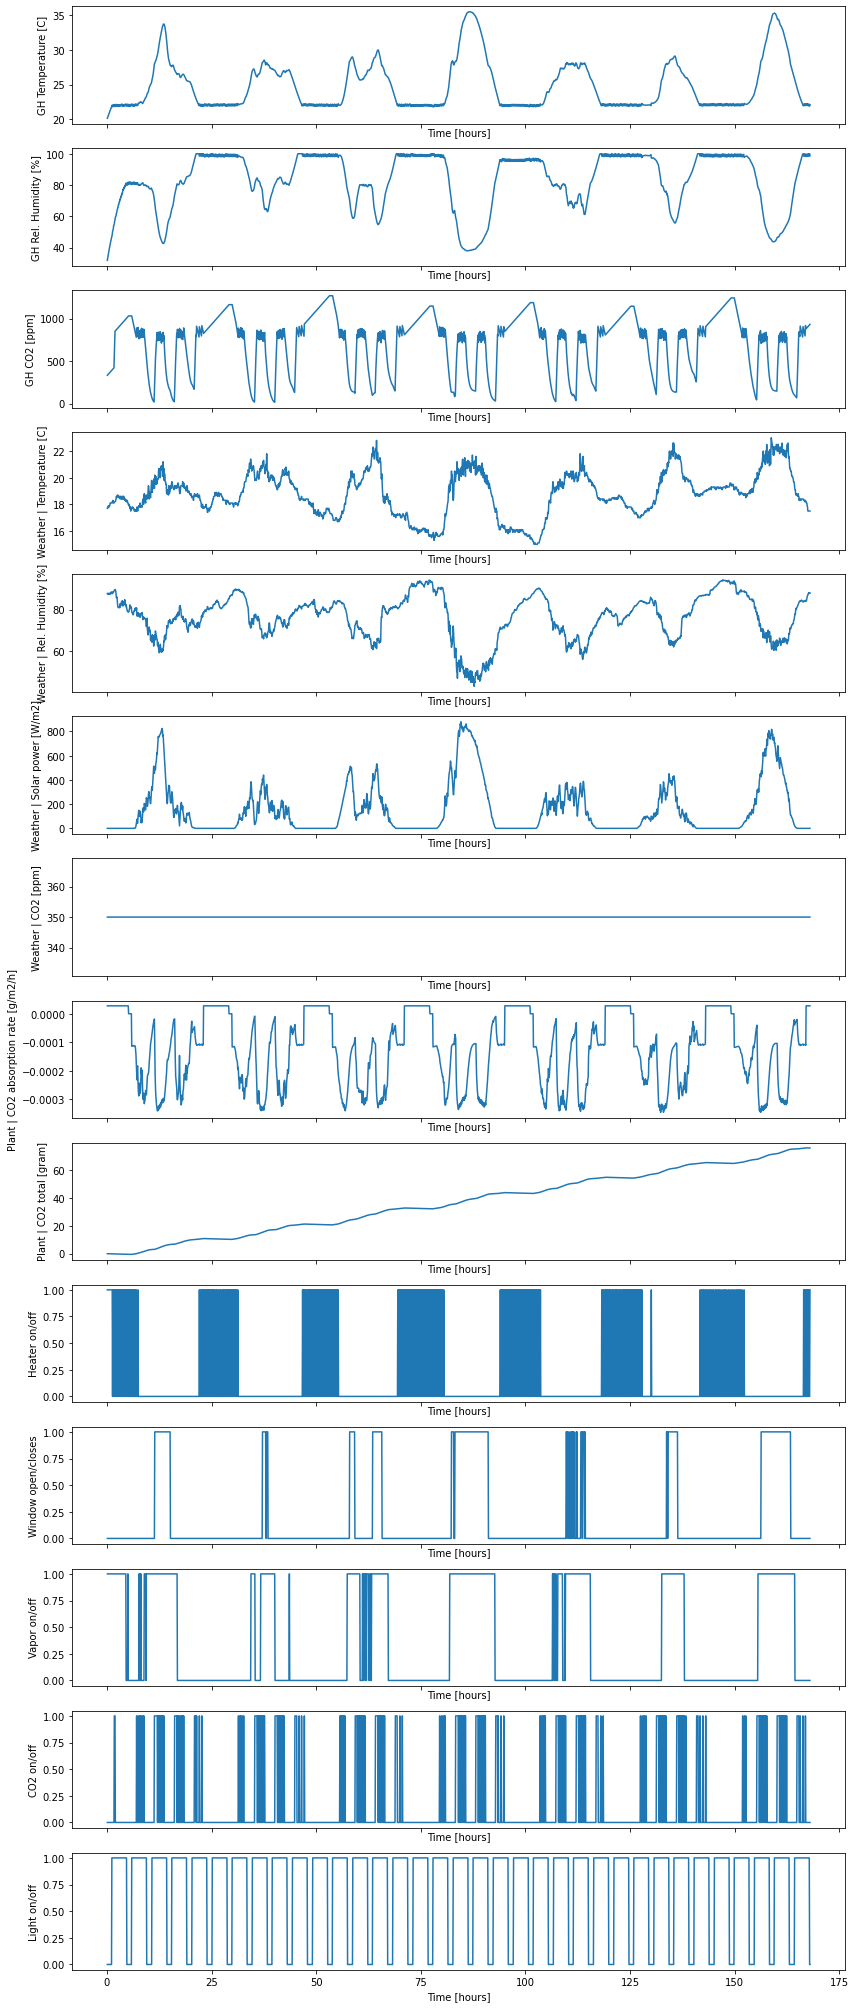

,mean_day_temp,mean_night_temp,cost_vapor,cost_heat,cost_CO2,cost_light,CO2_absorbed,total_cost,total_co2_absorbtion,total_reward
heuristic,25.818741,22.025044,0.0,-57.78,-84.5,-117.264583,505.193589,-259.544583,505.193589,245.649006


In [43]:
from greenhouse.heuristic_agents import HeuristicAgent 
from greenhouse.simulation import plot_history
env = GreenhouseEnv(env_config)
heuristic_agent = HeuristicAgent()

history_heuristic, summary_heuristic = visualize_episode(env, heuristic_agent)
pd.DataFrame(summary_heuristic, index=['heuristic'])

## DQN
We would need to spend some time calculating how to change our heuristic now. However, we can reuse our Reinforcement Learning agent and train it on the new environment.

In [45]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_3')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config))
    

print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.9,
    use_cnn=False,
    mlp_n_hidden=(32, 32, 64),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(128, ),
    mlp_value_act_f="tanh")
# q_network.load(filepath='Experiments/greenhouse_dqn_2/run100')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.9,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-6,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (11,), float32)
Action space: Discrete(32)


INFO:tensorflow:Assets written to: Experiments\greenhouse_dqn_2\best\assets


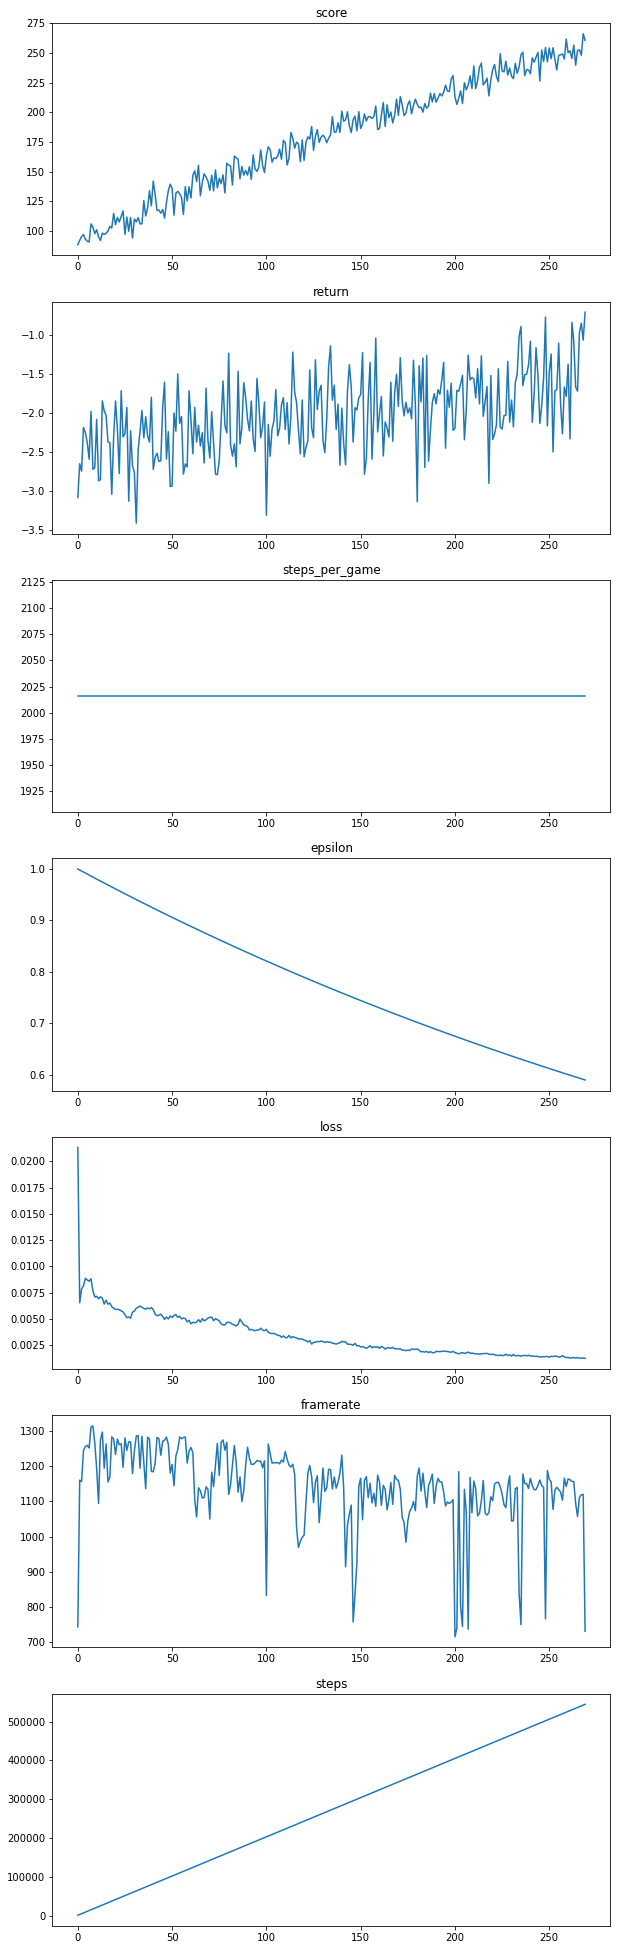

In [ ]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=2000, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

<ipython-input-37-2a062dc28d6e>:10: RuntimeWarning:

Mean of empty slice.



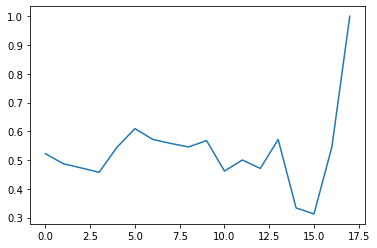

In [37]:
from plotly import graph_objects as go

# fig = go.Figure(
#     [go.Scatter(x=, y=history[:, -1], mode='markers')]
# )

d = []
for i in range(0, 20):
    idx = (i * 50 < history[:, 6]) * (history[:, 6] < i * 50 + 50)
    d.append(history[idx, -1].mean())
import matplotlib.pyplot as plt

plt.plot(d)